# Pure Python Implementation

In [76]:
import math as m 

In [ ]:
# support functions 
def sigmoid(values: list):
    return [1/(1 + m.exp(-x)) for x in values] 

def softmax(values: list):
    exp_values = [m.exp(value) for value in values]
    exp_sum = sum(exp_values)
    
    return [(x/exp_sum) for x in exp_values]

def weighted_sum(input: list, weights:list, bias: list):
    # initialize empty output list
    output = [0] * len(weights[0])

    # loop over number of weights per input (number of output)
    for i in range(len(weights[0])):
        # loop over number of input
        for j in range(len(input)):
            output[i] += input[j]*weights[j][i]
        output[i] += bias[i]
    
    return output
    

def predict(smax_output, target):
    return target[smax_output.index(max(smax_output))]

def forwardpass(input, w1, b1, w2, b2):
    # feedforward pass
    o1 = weighted_sum(input, w1, b1) # first linear combination
    h = sigmoid(o1) # sigmoid activation function
    o2 = weighted_sum(h, w2, b2) # second linear combination
    y = softmax(o2) # sigmoid activation function

    return o1, h, o2, y

def elemwise_mult(values1: list, values2: list):
    return [x * y for x, y in zip(values1, values2)]

def deriv_loss(values: list, target_idx):
    return [-1/x if values.index(x) == target_idx else 0 for x in values]

def deriv_sigmoid(values: list):
    sigmoid_vals = sigmoid(values)
    return [x*(1 - x) for x in sigmoid_vals]

def deriv_softmax(values: list, target_idx):
    deriv = [0] * len(values)
    for idx, value in enumerate(values):
        if idx == target_idx:
            deriv[idx] = value*(1 - value)
        else:
            deriv[idx] = (-1)*values[target_idx]*value
    
    return deriv

def get_loss(prediction, target):
    """ Calculate loss of current prediction """
    return - m.log(prediction[0]) if target[0] == 1 else -m.log(prediction[1])

def backprop(input, w1, b1, w2, b2, target, o1, h, o2, y):
    # calculate the loss
    loss = get_loss(y, target)
    target_idx = target.index(1)

    # backwards pass to compute derivatives
        # dL_dy = deriv_loss(y, target_idx) # (2, 0)
        # dL_do2 = elemwise_mult(dL_dy, deriv_softmax(y, target_idx)) # (2, )
    dL_do2 = [y[i] - target[i] for i in range(len(y))]
    dL_dw2 = [[x*y for x in dL_do2] for y in h] # (3, 2)
    dL_db2 = dL_do2
    dL_dh = [dL_do2[i]*w2[0][i] for i in range(len(dL_do2))]
    for i in range(len(dL_do2)):
        dL_dh[i] += dL_do2[i]*w2[1][i]
    dL_do1 = [dL_dh[i]* d_sig for d_sig in deriv_sigmoid(o1)]
    dL_dw1 = [[dL_do1[i]*input[j] for i in range(len(dL_do1))] for j in range(len(input))]
    dL_db1 = dL_do1 
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def forward_and_backward(input, w1, b1, w2, b2, target):
    # feedforward pass
    o1, h, o2, y = forwardpass(input, w1, b1, w2, b2)

    # backwards pass and get derivatives
    dL_dw1, dL_db1, dL_dw2, dL_db2, loss = backprop(input, w1, b1, w2, b2, target, o1, h, o2, y)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha):
    # update weights, biases in first layer 
    for i in range(len(w1)):
        for idx, w in enumerate(w1[i]):
            w1[i][idx] = w - alpha*dL_dw1[i][idx]
    
    for i in range(len(b1)):
        b1[i] =  b1[i] - alpha*dL_db1[i]

    # update weights, biases in second layer 
    for i in range(len(w2)):
        for idx, w in enumerate(w2[i]):
            w2[i][idx] = w - alpha*dL_dw2[i][idx]

    for i in range(len(b2)):
        b2[i] = b2[i] - alpha*dL_db2[i]

    return w1, b1, w2, b2 

#### Testting BackBropagation for derivatives

In [ ]:
# initial set up

# for testing 
input = [1, -1]
# weights for layer and bias 
w1 = [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]
b1 = [0.0, 0.0, 0.0]
w2 = [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]]
b2 = [0.0, 0.0]

# testing 
target = [1,0]
derivs  = forward_and_backward(input, w1, b1, w2, b2, target)
text = ["dL_dw1", "dL_db1", "dL_dw2", "dL_db2", "Loss"]
for idx, d in enumerate(derivs):
    print(f"{text[idx]} = {d}")

dL_dw1 = [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]
dL_db1 = [0.0, 0.0, 0.0]
dL_dw2 = [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
dL_db2 = [-0.5, 0.5]
Loss = 0.6931471805599453


## Training on a Dataset

In [83]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/" # "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [ ]:
import matplotlib.pyplot as plt
(xtrain, ytrain), (xval, yval), num_cls = load_synth()

# Training and plotting functions 
def plot_loss(avg_loss):
    """ Plot avg and epoch Loss """
    plt.figure(figsize=(8,5))
    plt.plot(avg_loss, label = "Avg Loss", linestyle = "-", color = "green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

def train(xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch):
    # epoch_loss = []
    avg_loss = []
    sample_size = xtrain.shape[0]

    for epoch in range(max_epoch):
    # start training in current epoch
        train_loss = 0 
        # training during epoch
        for i in range(sample_size):
            train_instance = np.random.randint(0, sample_size)
            # forward and backwards pass, returning the derivatives 
            target = [1, 0] if ytrain[train_instance] == 1 else [0, 1]
            dL_dw1, dL_db1, dL_dw2, dL_db2, loss = forward_and_backward(xtrain[train_instance], w1, b1, w2, b2, target)
            train_loss += loss
            # update weights
            w1, b1, w2, b2 = gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha)

        # calculate the avg loss of training
        avg_loss.append(train_loss/sample_size)

        # randomize dataset
        indices = np.arange(sample_size)
        xtrain = np.array([xtrain[i] for i in indices])
        ytrain = np.array([ytrain[i] for i in indices])


    print(f"w1 weights found = {w1}")
    print(f"b1 biases found = {b1}")
    print(f"w2 weights found = {w2}")
    print(f"b2 biases found = {b2}")

    return avg_loss


In [152]:
ytrain[:5]

array([1, 1, 1, 1, 0])

w1 weights found = [[-7.57551956 10.25949792 -1.86476699]
 [-6.84069862  3.48086033  3.03784819]]
b1 biases found = [6.27793828 6.24471487 2.3269719 ]
w2 weights found = [[-13.05034811  15.17569678]
 [-14.1632713   14.58850321]
 [-12.06720247  13.27323518]]
b2 biases found = [ 28.78250542 -28.78250542]


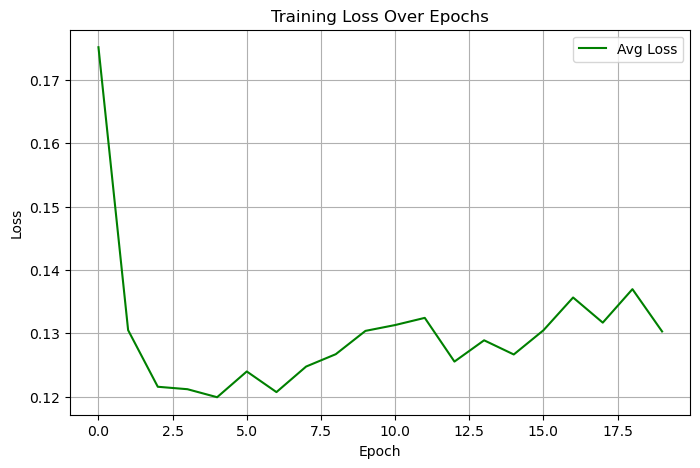

In [208]:
# initialization of weights 
w1 = np.random.normal(loc = 0.0, scale = 1.0, size=(2, 3))
b1 = np.zeros(3)
w2 = np.random.normal(loc = 0.0, scale = 1.0, size = (3,2))
b2 = np.zeros(2)

#normalization of data 
mean_xtrain = np.mean(xtrain, axis = 0)
sd_xtrain = np.std(xtrain, axis = 0)
norm_xtrain = (xtrain - mean_xtrain)/sd_xtrain
# train model
alpha = 0.1
max_epoch = 20
avg_loss = train(norm_xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch)

# plot loss
plot_loss(avg_loss)